In [1]:
import imageio
import numpy as np

import matplotlib.pyplot as plt
from silx.math.histogram import Histogramnd
import silx.math.fit
from scipy.interpolate import interp1d
from silx.math.fit import leastsq
import silx.gui.plot
import yaml
#%gui qt5
%matplotlib inline

/home/linus/miniconda3/envs/collimator_env/lib/python3.7/site-packages/silx/gui/plot/matplotlib/__init__.py:59: UserWarning: matplotlib.pyplot has already been imported, this call will have no effect.
  matplotlib.use(backend, warn=warn, force=force)


In [2]:
config_file="../examples/id31_draft/ring_raytracing.yml"
with open(config_file, "r") as stream:
    config = yaml.load(stream, Loader=yaml.SafeLoader)
    
no_soller_imgs="../"+config["output_dir"]+"/no_soller.gif"
soller_imgs="../"+config["output_dir"]+"/soller.gif"
shadow_imgs="../"+config["output_dir"]+"/shadow.gif"
#no_nothing_imgs="no_nothing.gif"


In [3]:
# calculate ring pattern
dis = config["ringpattern"]["pinhole_distance"]; #(*distance lightsource pinhole in mm*)
widthInRadian =  np.deg2rad(config["ringpattern"]["reflection_width"]) #(*natual width of the reflections*)
ringpos = np.deg2rad(config["ringpattern"]["ringpositions"]) #(*angular position of diffraction features*)

def CalcMinMaxRad(r): 
    return np.transpose(np.array([np.tan(r - widthInRadian/2)*dis,np.tan(r + widthInRadian/2)*dis]))

rings = CalcMinMaxRad(ringpos)
rings=np.array(rings).flatten()

##position in the simulation
sim_pos=np.arange(
    config["simulation_range"]["min"],
    config["simulation_range"]["max"],
    config["simulation_range"]["step"],
)

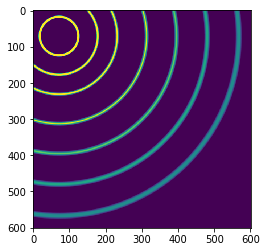

In [4]:
#calculate sum image without soller
no_soller=np.array(imageio.mimread(no_soller_imgs)).astype(int)
no_soller_sum=np.sum(no_soller,axis=0)
plt.imshow(no_soller_sum)

#get normalisation intensities
#no_nothing=np.array(imageio.mimread(no_nothing_imgs)).astype(int)


In [5]:
#p=silx.gui.plot.Plot2D()
#p.addImage(no_soller_sum)
#p.show()

In [6]:
def computeradius(data):
    
    # do the azimutal integration
    #xcenter=data.shape[0]/2
    #ycenter=data.shape[1]/2
    xcenter=72
    ycenter=72
    y, x=np.ogrid[:data.shape[0], :data.shape[1]]
    r=np.sqrt((x-xcenter)**2+(y-ycenter)**2)
    return r

In [7]:
radii=computeradius(no_soller_sum)

maxRadius=int(np.ceil(radii.max()))
nbbins=maxRadius
histo_range=[0,maxRadius]
histo, w_histo, edges = Histogramnd(radii.ravel(), 
                                    weights=no_soller_sum.astype(float).ravel(), 
                                    n_bins=nbbins, 
                                    histo_range=histo_range)
binscenter=(edges[0][1:] + edges[0][0:-1]) / 2.0
integration=w_histo/histo
integration=integration-integration.min()

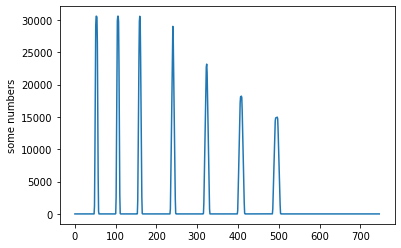

In [8]:
plt.plot(binscenter,integration)
plt.ylabel('some numbers')
plt.show()

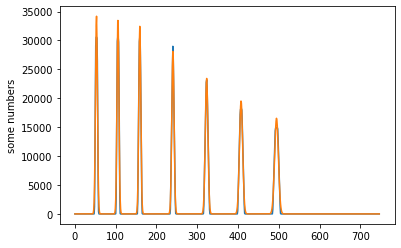

In [9]:
peakpos_px=silx.math.fit.peaks.peak_search(integration, 10, sensitivity=3.5)
#print(peakpos_px.shape, ringpos.shape)
peakpos=binscenter[peakpos_px.astype(int)]
#print(peakpos)

intens_guess=integration[peakpos_px.astype(int)]
fwhm_guess=silx.math.fit.peaks.guess_fwhm(integration)
fwhm_guess=np.ones(intens_guess.shape[0])*fwhm_guess
init_gues=np.transpose(np.array([intens_guess,peakpos_px,fwhm_guess])).ravel()
optimal_parameters, covariance, infodict  = silx.math.fit.leastsq(model=silx.math.fit.sum_gauss,
                    xdata=binscenter,
                    ydata=integration,
                    p0=init_gues,
                    full_output=True)



calib_fitted=silx.math.fit.sum_gauss(binscenter,optimal_parameters)

plt.plot(binscenter,integration)
plt.plot(binscenter,calib_fitted)
plt.ylabel('some numbers')
plt.show()

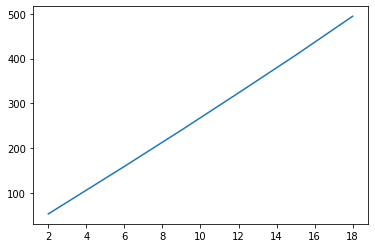

In [10]:
plt.plot(np.rad2deg(ringpos),peakpos)
plt.show()

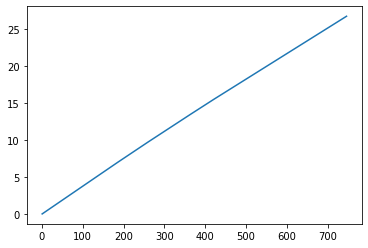

In [11]:
f = interp1d(peakpos,np.rad2deg(ringpos),fill_value="extrapolate")
x_in_deg=f(binscenter)
plt.plot(binscenter,x_in_deg)
#plt.ylabel('some numbers')
plt.show()

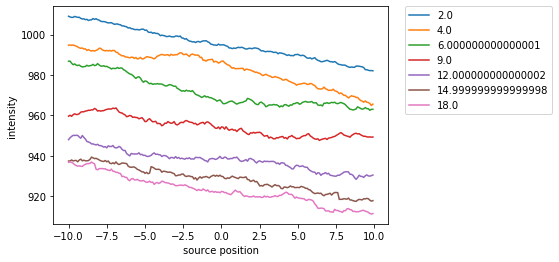

In [12]:
radial_intensities=[]

for i in range(0,sim_pos.shape[0]):    
    histo, w_histo, edges = Histogramnd(radii.ravel(), 
                                    #weights=(no_soller[i].astype(float)/no_nothing[i].astype(float)).ravel(), 
                                    weights=(no_soller[i].astype(float)).ravel(), 
                                    n_bins=nbbins, 
                                    histo_range=histo_range)
    integration_frame=w_histo/histo
    integration_frame=integration_frame-integration_frame.min()
    
    radial_intensities.append(integration_frame)

radial_intensities=np.array(radial_intensities)
    
optimal_parameters_formated=optimal_parameters.reshape(int(optimal_parameters.shape[0]/3),3)
optimal_fwhm=np.ceil(optimal_parameters_formated[:,2])*1.5

l_intens_nosoller=[]
j=0
for i in np.array([peakpos_px,optimal_fwhm]).transpose().astype(int):
    tmp=np.sum(radial_intensities[:,(i[0]-i[1]):(i[0]+i[1])],axis=1)
    l_intens_nosoller.append(tmp)
    plt.plot(sim_pos,tmp,label=str(np.rad2deg(ringpos[j])))
    j+=1
    plt.ylabel("intensity")
    plt.xlabel("source position")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

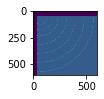

In [13]:
#calculate mask to shadow reflections outside of collimated area
shadow=np.array(imageio.mimread(shadow_imgs)).astype(int)
plt.subplot(3,1,1)
plt.imshow(shadow[1])

c10=np.argmin(np.sum(shadow[1],axis=0)[0:int(shadow[1].shape[1]/2)])
c11=np.argmin(np.sum(shadow[1],axis=0)[int(shadow[1].shape[1]/2):])+int(shadow[1].shape[1]/2)
c00=np.argmin(np.sum(shadow[1],axis=1)[0:int(shadow[1].shape[0]/2)])
c01=np.argmin(np.sum(shadow[1],axis=1)[int(shadow[1].shape[0]/2):])+int(shadow[1].shape[0]/2)


m=np.zeros_like(shadow[1])
m[c00::,c10::]=1
m=m.astype(np.int)

#now the same exersise with soller
#calculate sum image without soller
soller=np.array(imageio.mimread(soller_imgs)).astype(int)*m
soller_sum=np.sum(soller,axis=0)
plt.imshow(soller_sum)

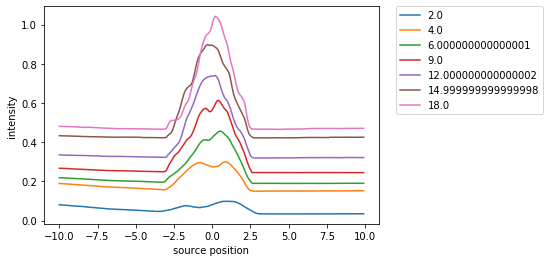

In [14]:
radial_intensities=[]

for i in range(0,sim_pos.shape[0]):    
    histo, w_histo, edges = Histogramnd(radii.ravel(), 
                                    weights=soller[i].astype(float).ravel(), 
                                    n_bins=nbbins, 
                                    histo_range=histo_range)
    integration_frame=w_histo/histo
    integration_frame=integration_frame-integration_frame.min()
    
    radial_intensities.append(integration_frame)

radial_intensities=np.array(radial_intensities)
    
optimal_parameters_formated=optimal_parameters.reshape(int(optimal_parameters.shape[0]/3),3)
optimal_fwhm=np.ceil(optimal_parameters_formated[:,2])*1.5

l_intens=[]
j=0
for i in np.array([peakpos_px,optimal_fwhm]).transpose().astype(int):
    tmp=np.sum(radial_intensities[:,(i[0]-i[1]):(i[0]+i[1])],axis=1)
    tmp=tmp/l_intens_nosoller[j]
    l_intens.append(tmp-np.min(tmp))
    plt.plot(sim_pos,tmp,label=str(np.rad2deg(ringpos[j])))
    j+=1
    plt.ylabel("intensity")
    plt.xlabel("source position")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

2.0    15.9329719045935
4.0    3.5611822513768647
6.0    3.0749270581794272
9.0    3.0896954099358536
12.0    2.823055045607061
15.0    2.892040535282124
18.0    2.5155645949166257


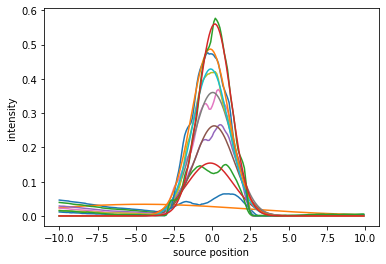

In [15]:
j=0
for l in l_intens:
    intens_guess=np.max(l)
    #fwhm_guess=silx.math.fit.peaks.guess_fwhm(l)
    ma=np.max(l)
    fwhm_guess=np.abs(sim_pos[np.argmax(l)]-np.abs(sim_pos[np.argmin(np.abs(l-ma/2))]))
    #fwhm_guess=1
    init_gues=np.array([intens_guess,0,fwhm_guess])
    optimal_parameters, covariance, infodict  = silx.math.fit.leastsq(model=silx.math.fit.sum_gauss,
                    xdata=sim_pos,
                    ydata=l,
                    p0=init_gues,
                    full_output=True)
    
    fitted=silx.math.fit.sum_gauss(sim_pos,optimal_parameters)

    plt.plot(sim_pos,l)
    plt.plot(sim_pos,fitted)

    plt.ylabel("intensity")
    plt.xlabel("source position")
    
    print(np.round(np.rad2deg(ringpos[j])),'  ',optimal_parameters[2])
    j+=1

Transmission: 0.5545099008213762


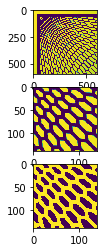

In [16]:
#calculate transmission
shadow=np.array(imageio.mimread(shadow_imgs)).astype(int)
plt.subplot(3,1,1)
plt.imshow(shadow[1])

c10=np.argmin(np.sum(shadow[1],axis=0)[0:int(shadow[1].shape[1]/2)])
c11=np.argmin(np.sum(shadow[1],axis=0)[int(shadow[1].shape[1]/2):])+int(shadow[1].shape[1]/2)
c00=np.argmin(np.sum(shadow[1],axis=1)[0:int(shadow[1].shape[0]/2)])
c01=np.argmin(np.sum(shadow[1],axis=1)[int(shadow[1].shape[0]/2):])+int(shadow[1].shape[0]/2)

plt.rcParams['figure.figsize']=[8,16]

m=np.zeros_like(shadow[1])
m[c00:c01,c10:c11]=1
m=m.astype(np.bool)
det=shadow[1]
det[np.logical_not(m)]=0
flat=shadow[0]
flat[np.logical_not(m)]=0
sub=np.abs(flat-det)
sub[sub>15]=1
sub[sub>1]=0
flat[flat>1]=1
#det[det>np.min(det[det>0])]=1
plt.subplot(3,1,2)
plt.imshow(det[180:320,180:320])
plt.subplot(3,1,3)
plt.imshow(sub[180:320,180:320])
print("Transmission:",np.sum(sub)/np.sum(flat))


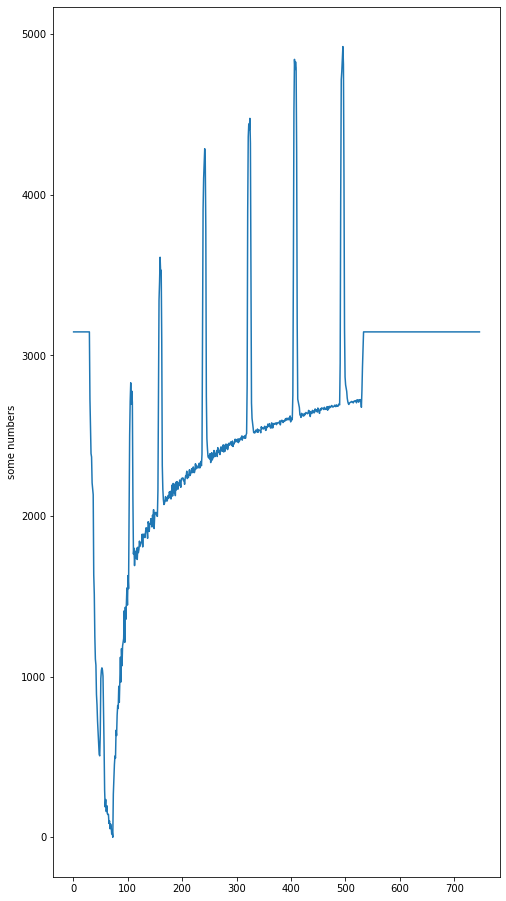

In [17]:
maxRadius=int(np.ceil(radii.max()))
nbbins=maxRadius
histo_range=[0,maxRadius]
histo, w_histo, edges = Histogramnd(radii.ravel(), 
                                    weights=soller_sum.astype(float).ravel(), 
                                    n_bins=nbbins, 
                                    histo_range=histo_range)
binscenter=(edges[0][1:] + edges[0][0:-1]) / 2.0
integration=w_histo/histo
integration=integration-integration.min()
plt.plot(binscenter,integration)
plt.ylabel('some numbers')
plt.show()